In [133]:
## Merge all lossses into single function to save computation
## Try the temporal thing (minimize from small times and increasing). Something similar to the idea in https://arxiv.org/pdf/2308.08468 , 5.1, but much more primitive
## TODO: Derive the solution at \Gamma_{in} at steady state

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [209]:
model_key = jax.random.PRNGKey(1)

input_dim = 2
output_dim = 'scalar'

layers_size = 10
n_layers = 1

model = eqx.nn.MLP(in_size=input_dim, out_size=output_dim, width_size=layers_size, depth=n_layers,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

In [267]:
sigma = 0.5**2


L = 3
T = 30

a = 0.9
b = 0.975


v_max = 1.5
p_max = 1 # rho_max cannot be learned Susana's paper

In [236]:
# Example batch input

batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])

In [237]:
def func(rho):
    return v_max*(1-rho/p_max)

def d_func(rho):
    return -(v_max/p_max) + 0*rho

In [268]:
def loss(model, sample, sigma, L, t, a, b, steps=50):

    # Data
    # To save computation, group all ranges of evaluation in a single input
    
    
        #Steady State range
    x_flat = jnp.linspace(0, L, steps)
    t_flat = jnp.full_like(x_flat, 50)
    steady_inputs = jnp.stack((x_flat, t_flat), axis=-1)

        #in_loss range
    t_flat = jnp.linspace(0.00, t, steps)
    x_flat = jnp.zeros_like(t_flat)
    in_inputs = jnp.stack((x_flat, t_flat), axis=-1)

        #out_loss range
    t_flat = jnp.linspace(0.00, t, steps)
    x_flat = jnp.full_like(t_flat, L)
    out_inputs = jnp.stack((x_flat, t_flat), axis=-1)

        #time_0_loss range
    x_flat = jnp.linspace(0, L, steps)
    t_flat = jnp.zeros_like(x_flat)
    time_inputs = jnp.stack((x_flat, t_flat), axis=-1)


    inputs = jnp.concat([sample, steady_inputs, in_inputs, out_inputs, time_inputs])
    n0 = 0
    n1 = len(sample)
    n2 = n1 + len(steady_inputs)
    n3 = n2 + len(in_inputs)
    n4 = n3 + len(out_inputs)
    n5 = n4 + len(time_inputs)



    # Derivatives
    rho, grad = jax.vmap(jax.value_and_grad(model))(inputs)
    hess = jax.vmap(jax.hessian(model))(inputs)

    dp_dx = grad[:, 0] 
    dp_dt = grad[:, 1]
    d2p_dx2 = hess[:, 0, 0]

    fp = func(rho)
    df_p = d_func(rho)

    j = jnp.array(-sigma*grad[:, 0] + rho * func(rho))

    # PDE
    pde_loss = dp_dt - sigma*d2p_dx2 + dp_dx*(fp + rho*df_p)

    # Steady state
    steady_loss = dp_dt[n1:n2] # Maybe the second derivative

    # in loss
    in_loss = -j[n2:n3] + a*(p_max-rho[n2:n3])

    # out loss
    out_loss = j[n3:n4] - b*rho[n3:n4]

    # time loss
    time_loss = rho[n4:]

    return jnp.average(pde_loss**2) + jnp.average(steady_loss**2) + jnp.average(in_loss**2) + jnp.average(out_loss**2) + jnp.average(time_loss**2)


In [269]:
loss(model, batch_input_data, sigma, L, 1, a, b)

Array(0.01283205, dtype=float32)

In [270]:
def generate_latin_hypercube_samples(num_samples, x1, t):
    # Define the ranges
    parameter_ranges = jnp.array([x1, t])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [271]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.gelu(layer(x))
        
        x = self.layers[-1](x)
        return x

In [272]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, sample, L, t, sigma, a, b, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, sample, sigma, L, t, a, b, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [273]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(1)


output_dim = 'scalar'

model = MLP(model_key, input_dim=2, hidden_dims=512, n_layers=6, output_dim=output_dim)

In [274]:
# Optimizer definition
lr = 10e-6
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(model)

In [286]:
# Training loop
num_epochs = 5000
losses = []



sample_n = 20
x = generate_latin_hypercube_samples(sample_n*num_epochs, [0,L], [0.0,T]) # Latin Hypercube sample


for epoch in range(num_epochs):
    
    sample = x[epoch*sample_n:(epoch+1)*sample_n]
    model, opt_state, loss_value = train_step(model, opt_state, sample, L, T, sigma, a, b, steps=50)
    if epoch % 100 == 0:
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")


    if epoch % 1000 == 0:
        lr *= 0.4
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate



# Print final loss
x = generate_latin_hypercube_samples(sample_n, [0,L], [0,T]) # Latin Hypercube sample
final_loss = loss(model, x, sigma, L, T, a, b, steps=20)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 0.0022092678118497133
Epoch 100, Loss: 0.0021788361482322216
Epoch 200, Loss: 0.004616481252014637
Epoch 300, Loss: 0.0020300422329455614


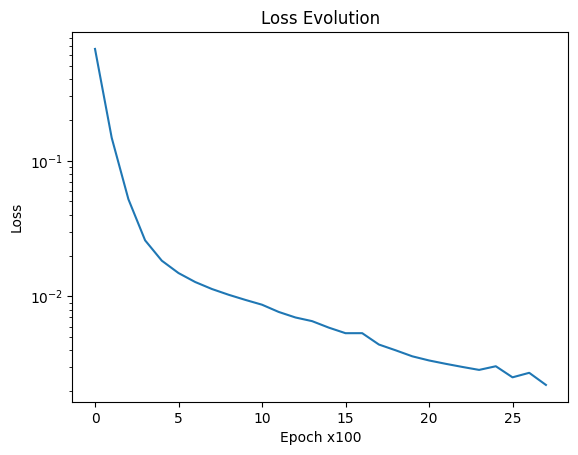

In [276]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

In [277]:
batch = generate_latin_hypercube_samples(5000, [0,L], [0.0,T]) 

In [278]:
loss(model, sample, sigma, L, T, a, b)

Array(0.00220759, dtype=float32)

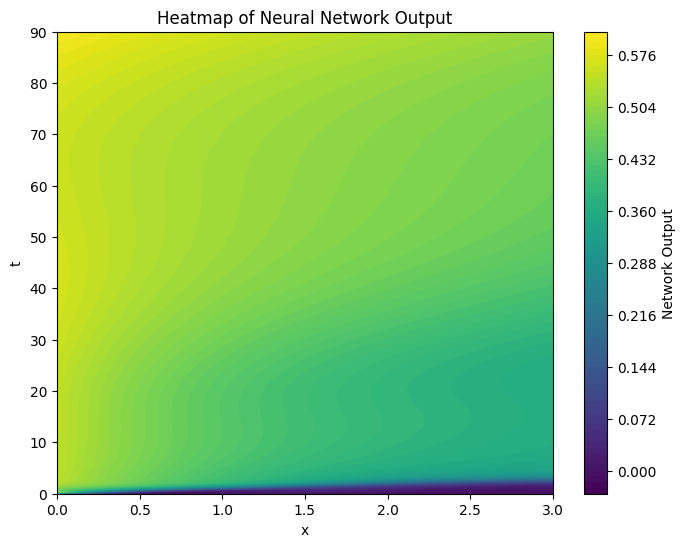

In [284]:
n_points = 300
#x = jnp.concat([jnp.linspace(0, 0.5, n_points), jnp.linspace(0.5, L-0.5, n_points), jnp.linspace(L-0.5, L, n_points)])
x_flat = jnp.linspace(0, L, n_points)
t_flat = jnp.linspace(0, 3*T, n_points)
X_grid, T_grid = jnp.meshgrid(x_flat, t_flat)
inputs = jnp.stack((X_grid.flatten(), T_grid.flatten()), axis=-1)


outputs = jax.vmap(model)(inputs)
outputs = outputs.reshape(len(t_flat), len(x_flat))


plt.figure(figsize=(8, 6))
plt.contourf(X_grid, T_grid, outputs, levels=100, cmap='viridis')
plt.colorbar(label='Network Output')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Heatmap of Neural Network Output')
plt.show()

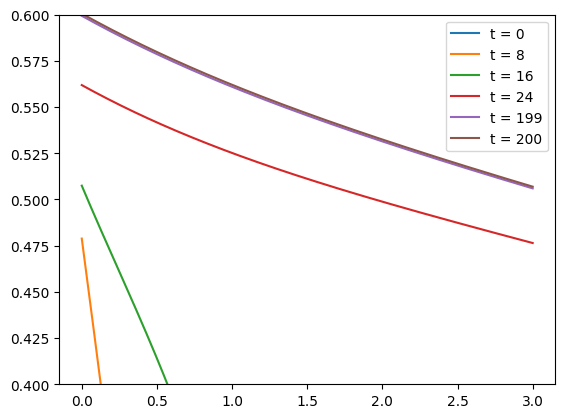

In [285]:
plt.plot(x_flat,outputs[0], label='t = 0')
plt.plot(x_flat,outputs[2], label='t = 8')
plt.plot(x_flat,outputs[5], label='t = 16')
plt.plot(x_flat,outputs[250], label='t = 24')
plt.plot(x_flat,outputs[-2], label='t = 199')
plt.plot(x_flat,outputs[-1], label='t = 200')
plt.ylim([0.4, 0.6])
plt.legend()
plt.show()

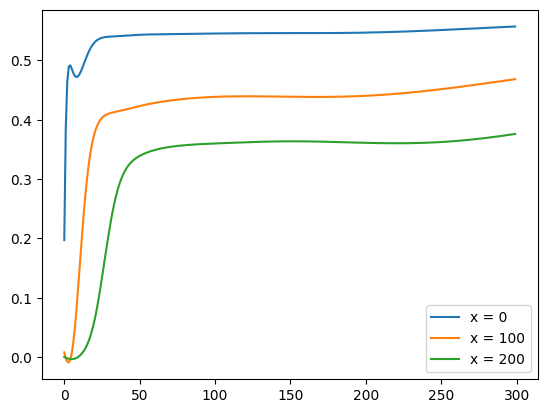

In [281]:
plt.plot(outputs.T[0], label='x = 0')
plt.plot(outputs.T[100], label='x = 100')
plt.plot(outputs.T[-1], label='x = 200')
plt.legend()
plt.show()